<b>Forcast Problem:</b> <br>
Predict "Weekly_Sales" (weekly sales) <br>
<br>
<b>DataSet:</b> <br>
https://www.kaggle.com/datasets/bletchley/course-material-walmart-challenge <br>
<br>
<b>DataSet Description:</b> <br>
<br>
Store - the store number <br>
Dept - the department number <br>
Date - the week <br>
Temperature - average temperature in the region <br>
Fuel_Price - cost of fuel in the region <br>
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and <br>
is not available for all stores all the time. Any missing value is marked with an NA. <br>
CPI - the consumer price index <br>
Unemployment - the unemployment rate <br>
IsHoliday - whether the week is a special holiday week <br>
Weekly_Sales: The weekly department wide sales (train set only <br>
Type: An anonymized description on which type of store it is <br>
Size: store size <br>
<br>
<br>
Holiday Events <br>
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 <br>
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 <br>
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 <br>
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13 <br>
<br>
<br>
<b>Causal Problem:</b> <br>
How "Type" (store type) impacts the "Weekly_Sales" (weekly sales) <br>
<br>
Causal discovery: <br>
    o/p: find causal graph <br>
Causal Identification: <br>
    o/p: probability expression <br>
Causal Estimation: <br>
    o/p: causal quantities such as ATE, CATE <br>
Causal Validation: <br>
    o/p: robustness scores for estimates <br>

In [3]:
import pandas as pd
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import shap

from econml.dml import DML
from econml.dr import DRLearner
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner
from econml.inference import BootstrapInference

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

In [4]:
sales_df_train = pd.read_csv("/Users/jaydeepchakraborty/JC/git-projects/model_util/DataSets/walmart_sale_challenge/train.csv")
sales_df_test = pd.read_csv("/Users/jaydeepchakraborty/JC/git-projects/model_util/DataSets/walmart_sale_challenge/test.csv")

In [5]:
print(sales_df_train.shape, sales_df_test.shape)

(282451, 16) (139119, 15)


In [6]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282451 entries, 0 to 282450
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         282451 non-null  int64  
 1   Dept          282451 non-null  int64  
 2   Date          282451 non-null  object 
 3   Weekly_Sales  282451 non-null  float64
 4   IsHoliday     282451 non-null  bool   
 5   Temperature   282451 non-null  float64
 6   Fuel_Price    282451 non-null  float64
 7   MarkDown1     100520 non-null  float64
 8   MarkDown2     74232 non-null   float64
 9   MarkDown3     91521 non-null   float64
 10  MarkDown4     90031 non-null   float64
 11  MarkDown5     101029 non-null  float64
 12  CPI           282451 non-null  float64
 13  Unemployment  282451 non-null  float64
 14  Type          282451 non-null  object 
 15  Size          282451 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 32.6+ MB


<font size=4> <b>Some Assumptions:</b> </font> <br>
Let's work on some assumtions and check how the data looks.    

<font size=3> <b>Assumption-1:</b> </font> <br>
Let's check whether "store type" has any influence on 'Weekly_Sales'

Type
A    20079.169258
B    12263.647825
C     9484.482310
Name: Weekly_Sales, dtype: float64


<AxesSubplot:xlabel='Type', ylabel='Weekly_Sales'>

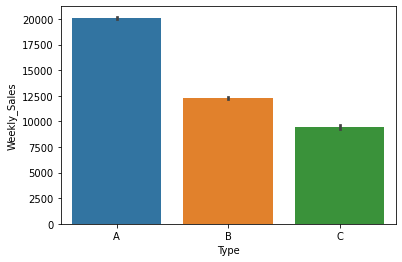

In [7]:
'''
From the plot,
It seems the "store type" might influence the "weekly sales"
'''
print(sales_df_train.groupby('Type')['Weekly_Sales'].mean())
sb.barplot(x="Type", y="Weekly_Sales", data=sales_df_train, estimator=np.mean)

In [8]:
# Applying the condition
sales_df_train['Type'].mask(sales_df_train['Type'] == 'A', 0, inplace=True)
sales_df_train['Type'].mask(sales_df_train['Type'] == 'B', 1, inplace=True)
sales_df_train['Type'].mask(sales_df_train['Type'] == 'C', 2, inplace=True)

sales_df_test['Type'].mask(sales_df_test['Type'] == 'A', 0, inplace=True)
sales_df_test['Type'].mask(sales_df_test['Type'] == 'B', 1, inplace=True)
sales_df_test['Type'].mask(sales_df_test['Type'] == 'C', 2, inplace=True)


# Applying the condition
sales_df_train['IsHoliday'].mask(sales_df_train['IsHoliday'] == True, 0, inplace=True)
sales_df_train['IsHoliday'].mask(sales_df_train['IsHoliday'] == False, 1, inplace=True)

sales_df_test['IsHoliday'].mask(sales_df_test['IsHoliday'] == True, 0, inplace=True)
sales_df_test['IsHoliday'].mask(sales_df_test['IsHoliday'] == False, 1, inplace=True)


# Another way to do is
# target_map = {"A": 0, "B": 1, "C": 2}
# df["Type"] = df["Type"].apply(lambda x: target_map[x])

Now use <b>causal analysis</b> to understand whether "store type" causes the "weekly sales"

In [ ]:
'''
Let's discuss the features we will consider for predicting 'weekly sales'
Store: it is number (identifier), we do not need it.
Type: different types of stores will have different sales. we will use it.
Size: different sizes of stores will have different sales. we will use it.
Dept: different dept will have different sales. we will use it.
Date: we will convert it to season (summer, spring, winter, Fall). different seasons will have different sales. we will use it.
IsHoliday: holiday will have different sales. we will use it.
Temperature: we will convert it to (hot: >75, medium: 50-75, cold:<50). different temperature will have different sales. we will use it.
'''

In [ ]:
'''
We need to define some variables.
Y = output
T = Treatment
X = co-variates used for heterogeneity
W = observable co-variates which has effect on Y, T (controls/confounders)
Z = variables that effect T (instrument variables)

In our problem,
Y = 'Weekly_Sales'
T = 'Type'
W = None
Z = None
X = ['Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI']
'''

In [9]:
# checking which columns are datatype ~ Object
for col_nm in sales_df_train.columns:
    print(col_nm, sales_df_train[col_nm].dtype)

Store int64
Dept int64
Date object
Weekly_Sales float64
IsHoliday object
Temperature float64
Fuel_Price float64
MarkDown1 float64
MarkDown2 float64
MarkDown3 float64
MarkDown4 float64
MarkDown5 float64
CPI float64
Unemployment float64
Type object
Size int64


In [10]:
# EconML does not consider object feature 
train_convert_dict = {'IsHoliday': int, 'Type': int} 
sales_df_train = sales_df_train.astype(train_convert_dict)

In [11]:
# EconML does not consider object feature 
test_convert_dict = {'IsHoliday': int,} 
sales_df_test = sales_df_test.astype(test_convert_dict)

#####################~~~~~~~~~~~~~~~~~~~~~~~~~~~~~####################################

<b>Double Machine Learning (DML)</b> <br>
$
\begin{align}
& \text{model_y:} \\
& \bar{Y} = Y - E[Y|X, W] \\
& \bar{Y} \text{is residual} \\
& \text{model_t:} \\
& \bar{T} = T - E[T|X, W] \\
& \bar{Y} \text{is residual} \\
& \text{model_final:} \\
& \text{estimator for } \bar{Y} \text{ and } \bar{T} \\
& Y=T*\theta(X)+f(X,W) ~ \text{linear final layer model}
\end{align}
$

In [12]:
dml_train_Y = sales_df_train['Weekly_Sales']
dml_train_T = sales_df_train['Type']
dml_train_W = None
dml_train_Z = None
dml_train_X = sales_df_train[['Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI']]
cat_cols_name = [0, 1] # ['Dept', 'IsHoliday']

In [13]:
dml_est = DML(
                model_y = HistGradientBoostingRegressor(random_state=42, categorical_features=cat_cols_name),
                model_t = HistGradientBoostingClassifier(random_state=42, categorical_features=cat_cols_name),
                model_final = ElasticNetCV(fit_intercept=False),
                discrete_treatment=True
            )

In [14]:
dml_est.fit(dml_train_Y, dml_train_T, X=dml_train_X, W=dml_train_W)

In [15]:
dml_est.summary()

Final model doesn't have a `coef_stderr_` and `intercept_stderr_` attributes, only point estimates will be available.
Final model doesn't have a `coef_stderr_` and `intercept_stderr_` attributes, only point estimates will be available.


,point_estimate
Dept|Type_1,-119.858
Dept|Type_2,-17.629
IsHoliday|Type_1,0.0
IsHoliday|Type_2,-0.0
Temperature|Type_1,37.481
Temperature|Type_2,-37.832
Fuel_Price|Type_1,1.142
Fuel_Price|Type_2,-1.881
CPI|Type_1,-37.093
CPI|Type_2,-70.069


In [16]:
print(f"features: {dml_est.cate_feature_names()}, output: {dml_est.cate_output_names()}, treatment: {dml_est.cate_treatment_names()}")

features: ['Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI'], output: ['Weekly_Sales'], treatment: ['Type_1', 'Type_2']


In [17]:
dml_test_T = sales_df_test['Type'].copy()
dml_test_W = None
dml_test_Z = None
dml_test_X = sales_df_test[['Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI']].copy()

In [18]:
dml_test_seg = dml_test_X.iloc[[2, 4, 5, 8, 13, 25, 0, 19, 90, 43]].copy()
# dml_test_seg.reset_index(inplace = True)
print(dml_test_seg)

    Dept  IsHoliday  Temperature  Fuel_Price         CPI
2      4          1        76.67       4.087  129.062355
4     52          1        45.12       2.841  126.436419
5     49          1        77.30       3.563  129.112500
8     33          1        86.13       3.594  218.450940
13    97          1        42.74       3.619  130.645793
25    35          1        77.16       3.570  129.066300
0     40          1        50.43       3.599  130.157516
19    97          1        81.76       3.311  220.614875
90    32          1        71.17       3.617  223.774444
43    19          1        79.14       3.263  130.701290


In [19]:
'''
# Calculate the heterogeneous treatment effect (.effect() result same)
# The treatment effect is the estimated average effect on Y from moving from T=0 to T=1, given X.
# The treatment effect is the estimated average effect on Y from moving from T=0 to T=2, given X.
# The treatment effect is the estimated average effect on Y from moving from T=1 to T=2, given X.
'''
dml_est_effect_01 = dml_est.effect_inference(dml_test_seg, T0=0, T1=1).summary_frame()
dml_est_effect_02 = dml_est.effect_inference(dml_test_seg, T0=0, T1=2).summary_frame()
dml_est_effect_12 = dml_est.effect_inference(dml_test_seg, T0=1, T1=2).summary_frame()
pd.concat([dml_est_effect_01, dml_est_effect_02, dml_est_effect_12], axis=1)

Final model doesn't have a `prediction_stderr` method, only point estimates will be returned.
Final model doesn't have a `prediction_stderr` method, only point estimates will be returned.
Final model doesn't have a `prediction_stderr` method, only point estimates will be returned.


,point_estimate,point_estimate,point_estimate
X,,,
0,-2388.360,-12022.055,-9633.695
1,-9228.088,-11488.294,-2260.206
2,-7760.801,-12841.707,-5080.907
3,-8825.905,-19153.623,-10327.718
4,-14866.138,-12487.955,2378.183
5,-6086.319,-12586.385,-6500.066
6,-7727.930,-11739.797,-4011.867
7,-16741.181,-20267.626,-3526.445
8,-9464.208,-18943.086,-9478.877


In [20]:
'''
It is avg of the heterogeneous treatment effect
(-2452.68684025 + -9247.30240787 + -7797.68497189 + -8897.88185871 + -14857.55620653 + -6131.75032643 + -7757.96018019 + -16772.17168246 + -9531.01731438 + -4211.9654078) / 10
(-12055.10096963 + -11552.18220685 + -12905.62839696 + -19225.4687011 + -12583.42088366 + -12640.69874982 + -11796.4801773 + -20383.55785019 + -19014.62893278 + -12537.00599772) / 10
(-9602.41412939 + -2304.87979898 + -5107.94342507 + -10327.58684239 + 2274.13532287 + -6508.94842339 + -4038.51999712 + -3611.38616773 + -9483.6116184 + -8325.04058993) / 10
'''
print(dml_est.ate(dml_test_seg, T0=0, T1=1))
print(dml_est.ate(dml_test_seg, T0=0, T1=2))
print(dml_est.ate(dml_test_seg, T0=1, T1=2))

-8724.430977726533
-14402.374694251723
-5677.9437165251875


In [41]:
'''
# Calculate the heterogeneous marginal effect
# The marginal effect is calculated around a base treatment point and averaged over the population of X.

First column,
moving 100% from control (T0) to T1 ~ it is same as dml_est_effect_01
Second column,
moving 100% from control (T0) to T2 ~ it is same as dml_est_effect_02

Moving 100% from T1 to T2 ~ means ~ moving 100% from T1 to control and then 100% from control to T2.
dml_est_effect_12 = second column - first column
'''
dml_marginal_effect = np.array(dml_est.marginal_effect(T=0, X=dml_test_seg))
print(dml_marginal_effect)

[[ -2388.35985059 -12022.05469621]
 [ -9228.0877648  -11488.29383954]
 [ -7760.80077149 -12841.70740953]
 [ -8825.90539628 -19153.62340299]
 [-14866.13838809 -12487.95528623]
 [ -6086.31896786 -12586.38533386]
 [ -7727.92958151 -11739.79689035]
 [-16741.18076907 -20267.62625791]
 [ -9464.20816466 -18943.08560711]
 [ -4155.38012291 -12493.2182188 ]]


In [44]:
'''
Moving 100% from T1 to T2 ~ means ~ moving 100% from T1 to control and then 100% from control to T2.
dml_est_effect_12 = second column - first column
'''
print((dml_marginal_effect[:, 1] - dml_marginal_effect[:, 0]))

[ -9633.69484563  -2260.20607474  -5080.90663804 -10327.7180067
   2378.18310186  -6500.066366    -4011.86730883  -3526.44548885
  -9478.87744245  -8337.83809588]


In [23]:
# Calculate the average constant marginal CATE 
# If treatment_featurizer is None, the base treatment is ignored in this calculation and the result is equivalent to marginal_effect.
dml_est.const_marginal_effect(X=dml_test_seg)

array([[ -2388.35985059, -12022.05469621],
       [ -9228.0877648 , -11488.29383954],
       [ -7760.80077149, -12841.70740953],
       [ -8825.90539628, -19153.62340299],
       [-14866.13838809, -12487.95528623],
       [ -6086.31896786, -12586.38533386],
       [ -7727.92958151, -11739.79689035],
       [-16741.18076907, -20267.62625791],
       [ -9464.20816466, -18943.08560711],
       [ -4155.38012291, -12493.2182188 ]])

In [379]:
'''
# Calculate the average marginal effect 
# The marginal effect is calculated around a base treatment point and averaged over the population of X.
# # If treatment_featurizer is None, the base treatment is ignored in this calculation and the result is equivalent to const_marginal_effect.
(-2452.68684025 + -9247.30240787 + -7797.68497189 + -8897.88185871 + -14857.55620653 + -6131.75032643 + -7757.96018019 + -16772.17168246 + -9531.01731438 + -4211.9654078) / 10
(-12055.10096963 + -11552.18220685 + -12905.62839696 + -19225.4687011 + -12583.42088366 + -12640.69874982 + -11796.4801773 + -20383.55785019 + -19014.62893278 + -12537.00599772) / 10
'''
print(dml_est.marginal_ate(T=0, X=dml_test_seg))

[ -8765.79771965 -14469.4172866 ]


In [380]:
# Calculate the average constant marginal CATE 
dml_est.const_marginal_ate(X=dml_test_seg)

array([ -8765.79771965, -14469.4172866 ])

    Dept  IsHoliday  Temperature  Fuel_Price         CPI
2      4          1        76.67       4.087  129.062355
4     52          1        45.12       2.841  126.436419
5     49          1        77.30       3.563  129.112500
8     33          1        86.13       3.594  218.450940
13    97          1        42.74       3.619  130.645793
25    35          1        77.16       3.570  129.066300
0     40          1        50.43       3.599  130.157516
19    97          1        81.76       3.311  220.614875
90    32          1        71.17       3.617  223.774444
43    19          1        79.14       3.263  130.701290


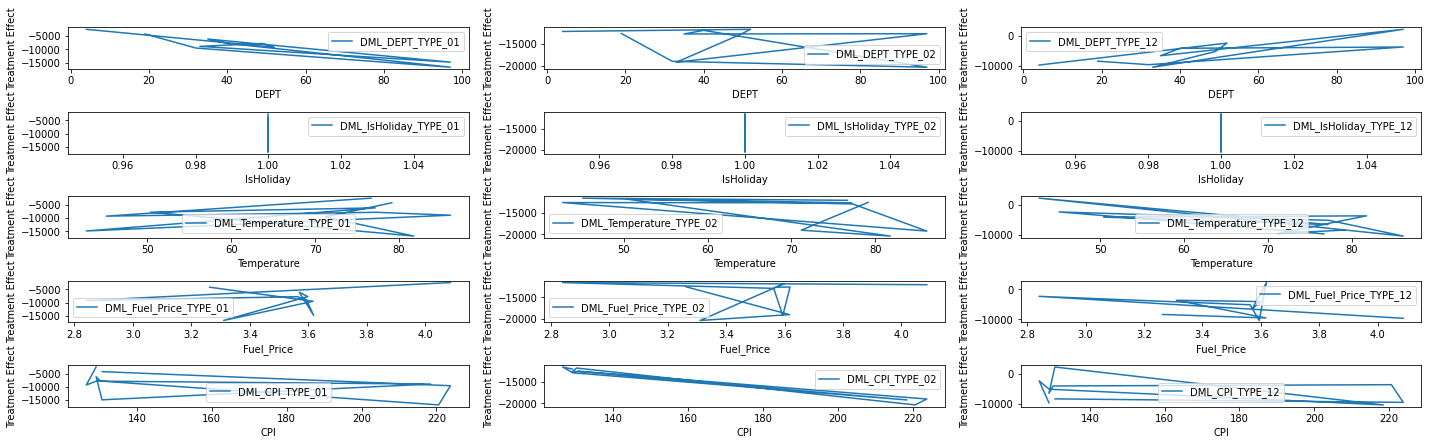

In [404]:
print(dml_test_seg)
plot_dml_test_seg_effect_01 = dml_est.effect(dml_test_seg, T0=0, T1=1)
plot_dml_test_seg_effect_02 = dml_est.effect(dml_test_seg, T0=0, T1=2)
plot_dml_test_seg_effect_03 = dml_est.effect(dml_test_seg, T0=1, T1=2)


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,6))

axes[0, 0].plot(dml_test_seg['Dept'], plot_dml_test_seg_effect_01, label='DML_DEPT_TYPE_01')
axes[0, 0].set(xlabel = 'DEPT', ylabel = 'Treatment Effect')
axes[0, 0].legend()

axes[0, 1].plot(dml_test_seg['Dept'], plot_dml_test_seg_effect_02, label='DML_DEPT_TYPE_02')
axes[0, 1].set(xlabel = 'DEPT', ylabel = 'Treatment Effect')
axes[0, 1].legend()

axes[0, 2].plot(dml_test_seg['Dept'], plot_dml_test_seg_effect_03, label='DML_DEPT_TYPE_12')
axes[0, 2].set(xlabel = 'DEPT', ylabel = 'Treatment Effect')
axes[0, 2].legend()

axes[1, 0].plot(dml_test_seg['IsHoliday'], plot_dml_test_seg_effect_01, label='DML_IsHoliday_TYPE_01')
axes[1, 0].set(xlabel = 'IsHoliday', ylabel = 'Treatment Effect')
axes[1, 0].legend()

axes[1, 1].plot(dml_test_seg['IsHoliday'], plot_dml_test_seg_effect_02, label='DML_IsHoliday_TYPE_02')
axes[1, 1].set(xlabel = 'IsHoliday', ylabel = 'Treatment Effect')
axes[1, 1].legend()

axes[1, 2].plot(dml_test_seg['IsHoliday'], plot_dml_test_seg_effect_03, label='DML_IsHoliday_TYPE_12')
axes[1, 2].set(xlabel = 'IsHoliday', ylabel = 'Treatment Effect')
axes[1, 2].legend()

axes[2, 0].plot(dml_test_seg['Temperature'], plot_dml_test_seg_effect_01, label='DML_Temperature_TYPE_01')
axes[2, 0].set(xlabel = 'Temperature', ylabel = 'Treatment Effect')
axes[2, 0].legend()

axes[2, 1].plot(dml_test_seg['Temperature'], plot_dml_test_seg_effect_02, label='DML_Temperature_TYPE_02')
axes[2, 1].set(xlabel = 'Temperature', ylabel = 'Treatment Effect')
axes[2, 1].legend()

axes[2, 2].plot(dml_test_seg['Temperature'], plot_dml_test_seg_effect_03, label='DML_Temperature_TYPE_12')
axes[2, 2].set(xlabel = 'Temperature', ylabel = 'Treatment Effect')
axes[2, 2].legend()

axes[3, 0].plot(dml_test_seg['Fuel_Price'], plot_dml_test_seg_effect_01, label='DML_Fuel_Price_TYPE_01')
axes[3, 0].set(xlabel = 'Fuel_Price', ylabel = 'Treatment Effect')
axes[3, 0].legend()

axes[3, 1].plot(dml_test_seg['Fuel_Price'], plot_dml_test_seg_effect_02, label='DML_Fuel_Price_TYPE_02')
axes[3, 1].set(xlabel = 'Fuel_Price', ylabel = 'Treatment Effect')
axes[3, 1].legend()

axes[3, 2].plot(dml_test_seg['Fuel_Price'], plot_dml_test_seg_effect_03, label='DML_Fuel_Price_TYPE_12')
axes[3, 2].set(xlabel = 'Fuel_Price', ylabel = 'Treatment Effect')
axes[3, 2].legend()

axes[4, 0].plot(dml_test_seg['CPI'], plot_dml_test_seg_effect_01, label='DML_CPI_TYPE_01')
axes[4, 0].set(xlabel = 'CPI', ylabel = 'Treatment Effect')
axes[4, 0].legend()

axes[4, 1].plot(dml_test_seg['CPI'], plot_dml_test_seg_effect_02, label='DML_CPI_TYPE_02')
axes[4, 1].set(xlabel = 'CPI', ylabel = 'Treatment Effect')
axes[4, 1].legend()

axes[4, 2].plot(dml_test_seg['CPI'], plot_dml_test_seg_effect_03, label='DML_CPI_TYPE_12')
axes[4, 2].set(xlabel = 'CPI', ylabel = 'Treatment Effect')
axes[4, 2].legend()

fig.tight_layout()

X has feature names, but FunctionTransformer was fitted without feature names


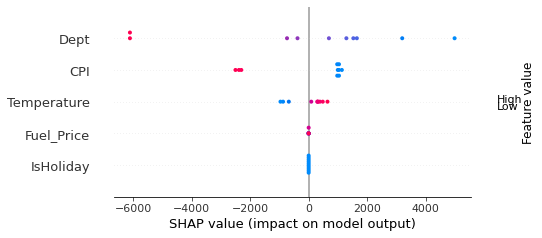

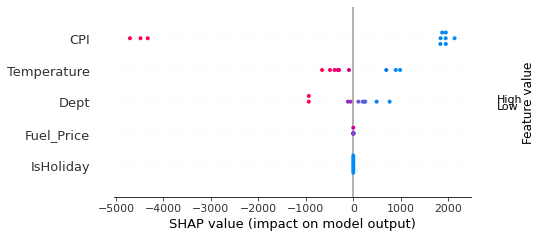

In [397]:
%matplotlib inline
# Shap value for the final stage models (const_marginal_effect)
dml_shap_vals = dml_est.shap_values(X=dml_test_seg, 
                                    feature_names=['Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI'], 
                                    treatment_names=['Type_1', 'Type_2'], 
                                    output_names=['Weekly_Sales'], 
                                    background_samples=100)


shap.summary_plot(dml_shap_vals['Weekly_Sales']['Type_1'])
shap.summary_plot(dml_shap_vals['Weekly_Sales']['Type_2'])

#####################~~~~~~~~~~~~~~~~~~~~~~~~~~~~~####################################

In [405]:
# Calculate the heterogeneous marginal effect
# The marginal effect is calculated around a base treatment point and averaged over the population of X.
# So T=0 to T=1 and 2
dml_est.marginal_effect(T=0, X=dml_test_seg)

array([[ -2452.68684025, -12055.10096963],
       [ -9247.30240787, -11552.18220685],
       [ -7797.68497189, -12905.62839696],
       [ -8897.88185871, -19225.4687011 ],
       [-14857.55620653, -12583.42088366],
       [ -6131.75032643, -12640.69874982],
       [ -7757.96018019, -11796.4801773 ],
       [-16772.17168246, -20383.55785019],
       [ -9531.01731438, -19014.62893278],
       [ -4211.9654078 , -12537.00599772]])

In [406]:
# Calculate the heterogeneous marginal effect
# The marginal effect is calculated around a base treatment point and averaged over the population of X.
# So T=0 to T=1 and 2
dml_est.marginal_effect(T=1, X=dml_test_seg)

array([[ -2452.68684025, -12055.10096963],
       [ -9247.30240787, -11552.18220685],
       [ -7797.68497189, -12905.62839696],
       [ -8897.88185871, -19225.4687011 ],
       [-14857.55620653, -12583.42088366],
       [ -6131.75032643, -12640.69874982],
       [ -7757.96018019, -11796.4801773 ],
       [-16772.17168246, -20383.55785019],
       [ -9531.01731438, -19014.62893278],
       [ -4211.9654078 , -12537.00599772]])

In [407]:
dml_est.marginal_effect(T=2, X=dml_test_seg)

array([[ -2452.68684025, -12055.10096963],
       [ -9247.30240787, -11552.18220685],
       [ -7797.68497189, -12905.62839696],
       [ -8897.88185871, -19225.4687011 ],
       [-14857.55620653, -12583.42088366],
       [ -6131.75032643, -12640.69874982],
       [ -7757.96018019, -11796.4801773 ],
       [-16772.17168246, -20383.55785019],
       [ -9531.01731438, -19014.62893278],
       [ -4211.9654078 , -12537.00599772]])

In [409]:
dml_est.marginal_effect(T=120, X=dml_test_seg)

array([[ -2452.68684025, -12055.10096963],
       [ -9247.30240787, -11552.18220685],
       [ -7797.68497189, -12905.62839696],
       [ -8897.88185871, -19225.4687011 ],
       [-14857.55620653, -12583.42088366],
       [ -6131.75032643, -12640.69874982],
       [ -7757.96018019, -11796.4801773 ],
       [-16772.17168246, -20383.55785019],
       [ -9531.01731438, -19014.62893278],
       [ -4211.9654078 , -12537.00599772]])

# Resources
1) https://aws.amazon.com/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/
2) https://www.kaggle.com/code/graymant/pytorch-regression-with-sklearn-pipelines
3) https://www.kaggle.com/code/sermakarevich/sklearn-pipelines-tutorial
4) https://www.kaggle.com/code/glongpan/explore-demand-system-of-avocados
5) https://www.kaggle.com/code/aslanahmedov/walmart-sales-forecasting/input
6) https://www.kaggle.com/code/baghern/a-deep-dive-into-sklearn-pipelines
7) https://towardsdatascience.com/double-machine-learning-for-causal-inference-78e0c6111f9d
8) https://matheusfacure.github.io/python-causality-handbook/landing-page.html
9) https://machinehack.com/story/building-a-causal-inference-model-using-econml
10) https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7
11) https://statmodeling.stat.columbia.edu/2020/06/30/understanding-the-average-treatment-effect-number/
12) https://www.youtube.com/watch?v=tUz2yl2QEbY&list=PLyvUJLHD8IsJCB7ALqwjRG1BjL5JxE__H

In [ ]:
Continuous treatment:
    https://github.com/py-why/EconML/issues/667
    https://github.com/py-why/EconML/issues/714
    https://github.com/py-why/EconML/issues/676
    https://github.com/py-why/EconML/issues/650
    https://github.com/py-why/EconML/issues/643
    https://github.com/py-why/EconML/issues/614